#Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

As evaluation metric we use the mean classification accuracy for the two components.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt

#Data Loading and preprocessing


In [ ]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()

# Verify data shapes
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

# Normalizing the images to the range [0, 1]
cifar10_x_train = (cifar10_x_train / 255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test / 255.).astype(np.float32)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Let us split the images in two groups, according to their label.

In [ ]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

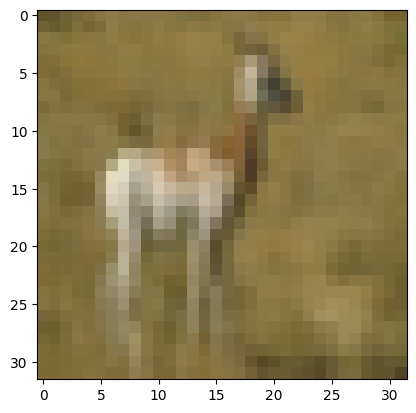

In [ ]:
plt.imshow(cifar10_x_train_1[34])

Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.


In [ ]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (tf.convert_to_tensor(Y1_cat[num1]), tf.convert_to_tensor(Y2_cat[num2]))

    yield x_data, y_data

Let us instantiate a generator on Cifar10 with batchsize=1, and let's check its behaviour.

In [ ]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.


first: airplane, second = ship


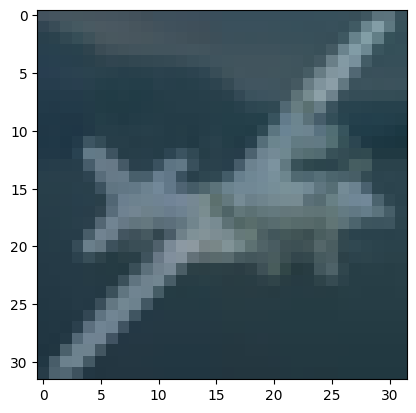

In [ ]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
plt.imshow(x[0])

## Model

We use the AdamW optimizer with categorical_crossentropy as loss function. During training, we adopt `EarlyStopping` to avoid overfitting and `ReduceLROnPlateau` to dynamically adapt the learning rate.

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

BATCH_SIZE = 256

optimizer = optimizers.AdamW(learning_rate=0.001)
loss={"out1": "categorical_crossentropy", "out2": "categorical_crossentropy"}
metrics=["accuracy", "accuracy"]

X_train_1, X_val_1, Y_train_1, Y_val_1 = train_test_split(
    cifar10_x_train_1, cifar10_y_train_1, test_size=0.1, random_state=42
)
X_train_2, X_val_2, Y_train_2, Y_val_2 = train_test_split(
    cifar10_x_train_2, cifar10_y_train_2, test_size=0.1, random_state=42
)

# Generatori con i nuovi set di dati
train_generator = datagenerator(X_train_1, X_train_2, Y_train_1, Y_train_2, BATCH_SIZE)
val_generator = datagenerator(X_val_1, X_val_2, Y_val_1, Y_val_2, BATCH_SIZE)


# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=3, min_lr=1e-4)

## Residual Block
`conv_block` is a residual block, composed by two/three convolutional layers, usually intermixed with BatchNomralization layers.


Il pooling opzionale consente di ridurre la dimensionalità spaziale, mentre il dropout aggiunge regolarizzazione per prevenire l’overfitting.

In [ ]:
def conv_block(filters, x, pooling=True):
    shortcut = x

    x = layers.Conv2D( filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    x = layers.Conv2D( filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    x = layers.Conv2D( filters, kernel_size=1, padding="same")(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D( filters, kernel_size=1, padding="same")(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU(alpha=0.1)(x)

    # optinal Pooling
    if pooling:
        x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    return x

## The model
The `my_net` function defines a CNN designed to work with images of size 32x32x3.

The network uses a series of convolutional blocks to extract features from the data, alternating convolutions with and without pooling to maintain a good balance between detail and dimensionality reduction.

After feature extraction, the network branches into two dense outputs, each with 5 neurons and a softmax activation, suitable for multiclass classification on the two groups in question in the dataset.

In [ ]:
def my_net(input_shape=(32, 32, 3)):
    inputs = layers.Input(input_shape)

    x = inputs
    x = conv_block(32, x, pooling=False)
    x = conv_block(64, x)
    x = conv_block(128, x, pooling=False)
    x = conv_block(196, x)
    x = conv_block(256, x)
    x = layers.Flatten()(x)

    #branching
    output1 = layers.Dense(5, activation="softmax", name="out1")(x)
    output2 = layers.Dense(5, activation="softmax", name="out2")(x)

    return Model(inputs, [output1, output2])

Let us compile the network and show the summary

In [ ]:
model = my_net()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 32, 32, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │          1,056 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 32)     │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 32)     │            128 │ leaky_re_lu_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 32)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyR

 Total params: 2,165,050 (8.26 MB)

 Trainable params: 2,159,642 (8.24 MB)

 Non-trainable params: 5,408 (21.12 KB)

Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=1300,
    epochs=100,
    validation_data=val_generator,
    validation_steps=300,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/100
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - loss: 2.8151 - out1_accuracy: 0.4459 - out1_loss: 1.4587 - out2_accuracy: 0.5035 - out2_loss: 1.3564 - val_loss: 1.8249 - val_out1_accuracy: 0.6010 - val_out1_loss: 1.0144 - val_out2_accuracy: 0.6984 - val_out2_loss: 0.8105 - learning_rate: 0.0010
Epoch 2/100
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - loss: 1.8414 - out1_accuracy: 0.6059 - out1_loss: 1.0373 - out2_accuracy: 0.7117 - out2_loss: 0.8041 - val_loss: 1.8707 - val_out1_accuracy: 0.5787 - val_out1_loss: 1.0671 - val_out2_accuracy: 0.7001 - val_out2_loss: 0.8036 - learning_rate: 0.0010
Epoch 3/100
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - loss: 1.5556 - out1_accuracy: 0.6603 - out1_loss: 0.8915 - out2_accuracy: 0.7589 - out2_loss: 0.6640 - val_loss: 1.4794 - val_out1_accuracy: 0.6614 - val_out1_loss: 0.8738 - val_out2_accuracy: 0.7766 - val_out2_loss: 0.6056 - learning_rate: 0.0010
Epoch 4/100
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - loss: 1.3691 - out1_

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-69f7bea9fe13>", line 1, in <cell line: 0>
    history = model.fit(
              ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function
    if not opt_outputs.has_value():
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py", line 321, in __bool__
    return bool(self._numpy())
                ^^^^^^^^^^^^^
  File "

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-69f7bea9fe13>", line 1, in <cell line: 0>
    history = model.fit(
              ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function
    if not opt_outputs.has_value():
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py", line 321, in __bool__
    return bool(self._numpy())
                ^^^^^^^^^^^^^
  File "

TypeError: object of type 'NoneType' has no len()

Training info

NameError: name 'history' is not defined

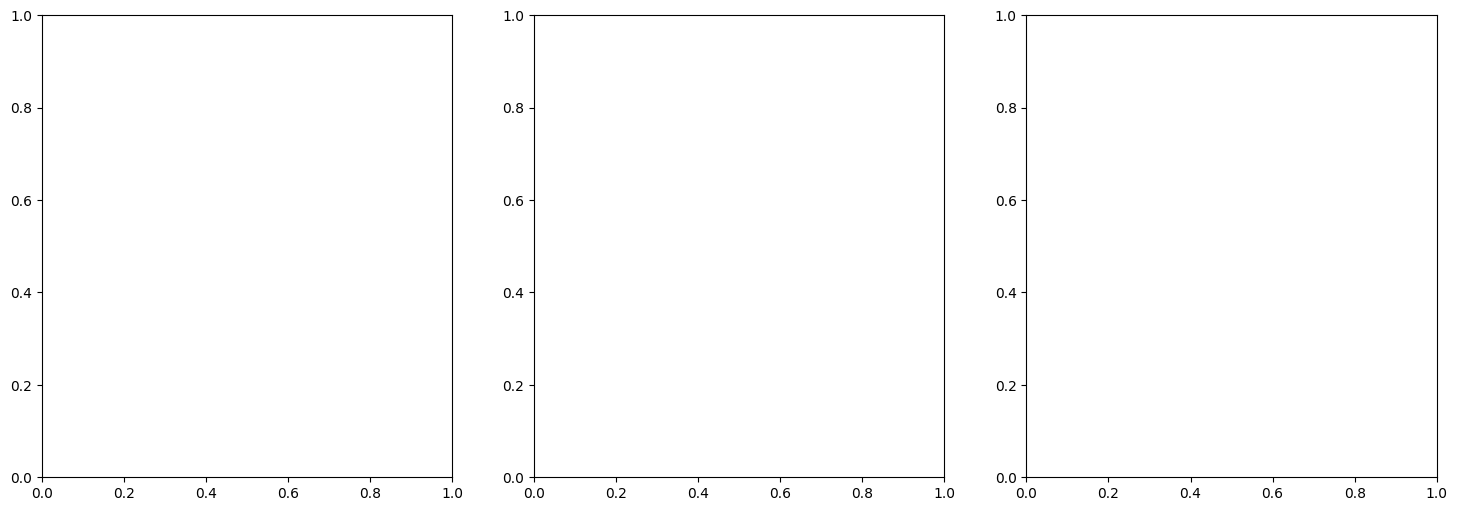

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

fig, (grafico1, grafico2, grafico3) = plt.subplots(1, 3, figsize=(18, 6))

colori = {
    "out1_loss": "#e74c3c", "val_out1_loss": "#ffb3b3",
    "out2_loss": "#3498db", "val_out2_loss": "#85c1e9",
    "out1_accuracy": "#27ae60", "val_out1_accuracy": "#a9dfbf",
    "out2_accuracy": "#9b59b6", "val_out2_accuracy": "#d7bde2",
    "learning_rate": "#f1c40f"
}

# Loss
grafico1.plot(history["out1_loss"], label="Train Loss (out1)", color=colori["out1_loss"], linewidth=2)
grafico1.plot(history["val_out1_loss"], label="Val Loss (out1)", color=colori["val_out1_loss"], linestyle="--", linewidth=2)
grafico1.plot(history["out2_loss"], label="Train Loss (out2)", color=colori["out2_loss"], linewidth=2)
grafico1.plot(history["val_out2_loss"], label="Val Loss (out2)", color=colori["val_out2_loss"], linestyle="--", linewidth=2)
grafico1.set_title("Loss history", fontsize=16)
grafico1.set_xlabel("Epochs", fontsize=12)
grafico1.set_ylabel("Loss", fontsize=12)
grafico1.legend(fontsize=10)
grafico1.grid(True)

# Accuracy
grafico2.plot(history["out1_accuracy"], label="Train Accuracy (out1)", color=colori["out1_accuracy"], linewidth=2)
grafico2.plot(history["val_out1_accuracy"], label="Val Accuracy (out1)", color=colori["val_out1_accuracy"], linestyle="--", linewidth=2)
grafico2.plot(history["out2_accuracy"], label="Train Accuracy (out2)", color=colori["out2_accuracy"], linewidth=2)
grafico2.plot(history["val_out2_accuracy"], label="Val Accuracy (out2)", color=colori["val_out2_accuracy"], linestyle="--", linewidth=2)
grafico2.set_title("Accuracy history", fontsize=16)
grafico2.set_xlabel("Epoche", fontsize=12)
grafico2.set_ylabel("Accuracy", fontsize=12)
grafico2.legend(fontsize=10)
grafico2.grid(True)

# Learning Rate
grafico3.plot(history.history["learning_rate"], label="Learning Rate", color=colori["learning_rate"], linewidth=2)
grafico3.set_title("Learning Rate history", fontsize=16)
grafico3.set_xlabel("Epoche", fontsize=12)
grafico3.set_ylabel("Learning Rate", fontsize=12)
grafico3.legend(fontsize=10)
grafico3.grid(True)

plt.show()

# Evalaution


Now let's use the test generator and proceed with the evaluation of my model.


In [ ]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


In [ ]:
def eval_model(model):
    eval_samples_x, eval_samples_y = next(testgen)
    predictions = model.predict(eval_samples_x)
    predictions_list = np.column_stack([np.argmax(predictions[0], axis=1), np.argmax(predictions[1], axis=1)])
    correct_guesses_1 = predictions_list[:, 0] == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = predictions_list[:, 1] == np.argmax(eval_samples_y[1], axis=1)
    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

Let's repeat the evaluation on my model 10 times so that we can analyze its standard deviation of the measured accuracy.

In [ ]:
repeat_eval = 10
eval_results = []

for i in range(repeat_eval):
    em = eval_model(model)
    print("accuracy", i+1, "=",em)
    eval_results.append(em)

# Risultati finali
print("------------------------------------------")
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
accuracy 1 = 0.85635
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
accuracy 2 = 0.8539
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
accuracy 3 = 0.8499
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
accuracy 4 = 0.85375
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
accuracy 5 = 0.8527499999999999
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
accuracy 6 = 0.85005
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
accuracy 7 = 0.8492500000000001
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
accuracy 8 = 0.85185
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
accuracy 9 = 0.85385
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
accuracy 10 = 0.8504499999999999
------------------------------------------
mean accuracy =  0.85221
standard deviation =  0.002175752743305165
